# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: Bor-Jiun Tseng

**ID**:bt366

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\nobel\OneDrive\桌面\BEE5750\hw\hw3-t1`
   Installed InlineStrings ─────────── v1.4.2
   Installed SentinelArrays ────────── v1.4.5
   Installed Calculus ──────────────── v0.5.1
   Installed StatsFuns ─────────────── v1.3.1
   Installed Pango_jll ─────────────── v1.52.2+0
   Installed PtrArrays ─────────────── v1.2.0
   Installed HypergeometricFunctions ─ v0.3.23
   Installed TranscodingStreams ────── v0.11.1
   Installed Rmath ─────────────────── v0.7.1
   Installed Rmath_jll ─────────────── v0.4.2+0
   Installed DualNumbers ───────────── v0.6.8
   Installed QuadGK ────────────────── v2.9.4
   Installed FillArrays ────────────── v1.11.0
   Installed Distributions ─────────── v0.25.109
Precompiling project...
  ✓ PtrArrays
  ✓ InlineStrings
  ✓ TranscodingStreams
  ✓ Calculus
  ✓ FillArrays
  ✓ PooledArrays
  ✓ SentinelArrays
  ✓ FilePathsBase
  ✓ StringManipulation
  ✓ Rmath_jll
  ✓ Dbus_jll
  ✓ AliasTables
  ✓ TranscodingStreams → TestExt
  ✓ OpenSpecFu

In [3]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

Plotting problem
1. Create a function for Streeter-Phelps equation for dissolved oxygen.
2. set river properties and waste 1 properties
3. plug in the river properties and waste1 properties to get the intial condition
4. plug in the number for 0>15 km which is before 2nd discharge
5. calculate the initial codition for second discharge, and plug in the number to get 15km>50km(35km total)
6. plot the graph for 1st discharge and second discharge
7. use min function to get minimum value for the graph is around 3.45mg/L

3.45 mg/L


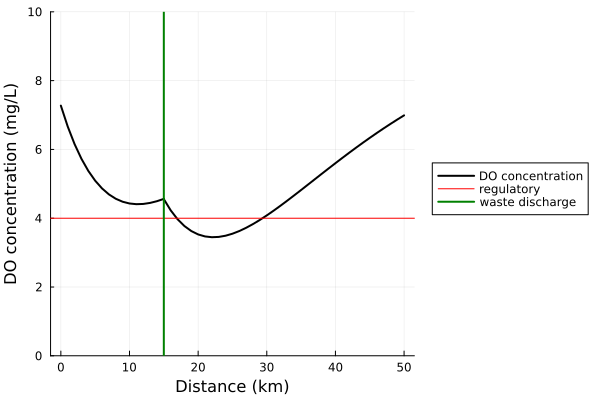

In [106]:
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc / (ka - kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn / (ka - kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    
    return (C, B, N)
end

# Set river properties
ka = 0.55
kc = 0.35
kn = 0.25
C0 = 7.5  
B0 = 5  
N0 = 5    
Cs = 10  
U = 6 

# Waste stream 1 properties
Q_waste1 = 10000 
C_waste1 = 5.0   
B_waste1 = 50.0  
N_waste1 = 50.0   

# River flow rate
Q_river = 100000  # m³/day

# Define the range for x (distance downstream in km)
x = 0:15  # km
C1 = (Q_river * C0 + Q_waste1 * C_waste1) / (Q_river + Q_waste1)
B1 = (Q_river * B0 + Q_waste1 * B_waste1) / (Q_river + Q_waste1)
N1 = (Q_river * N0 + Q_waste1 * B_waste1) / (Q_river + Q_waste1)  
# Run the simulation with waste stream 1 at 0 km to 15km
do_out_waste1 = (y -> do_simulate(y, C1, B1, N1, ka, kc, kn, Cs, U)).(x)

# Unpack outputs into individual arrays for C, B, and N
C15 = [d[1] for d in do_out_waste1]  # DO concentration
B15 = [d[2] for d in do_out_waste1]  # CBOD concentration
N15 = [d[3] for d in do_out_waste1]  # NBOD concentration

# Waste stream 2 properties
Q_waste2 = 15000
C_waste2 = 5.0
B_waste2 = 45.0
N_waste2 = 35

C2i = ((Q_river + Q_waste1)*C15[15] + (Q_waste2*C_waste2))/(Q_river + Q_waste1 + Q_waste2)
B2i = ((Q_river + Q_waste1)*B15[15] + (Q_waste2*B_waste2))/(Q_river + Q_waste1 + Q_waste2)
N2i = ((Q_river + Q_waste1)*N15[15] + (Q_waste2*N_waste2))/(Q_river + Q_waste1 + Q_waste2)

x2 = 0:35

do_out_waste2 = (y -> do_simulate(y, C2i, B2i, N2i, ka, kc, kn, Cs, U)).(x2)

C50 = [d[1] for d in do_out_waste2]
B50 = [d[2] for d in do_out_waste2]
N50 = [d[3] for d in do_out_waste2]
min_C50 = round(minimum(C50), digits = 2)
println(min_C50, " mg/L")
p1 = plot(; ylabel = "DO concentration (mg/L)", xlabel="Distance (km)", legend=:outerright,)
plot!(p1, 0:15, C15, color=:black, linewidth=2, label="DO concentration")
plot!(p1, 15:50, C50, color=:black, linewidth=2, label=false)
hline!([4], color=:red, label ="regulatory")
vline!([15], color=:green, linewidth = 2, label ="waste discharge")
yaxis!((0,10))

treatment problem
Only treating 1
1. create a function with treatment using the previous function
2. create a function for discharge point 2 using the simulate_with_treatment
3. use a for loop to check treatment options, and if concentration is >=4, we'll export the ratio.
4. get the minimum treatment % is around 29%.
Only treating 2
1. Creat a function that finds minimal treatment for waste 2, instead of waste 1, and if concentration is >=4 at 15-50km, export the ratio.
2. minimum treatment% is around 23%

In [120]:
function simulate_with_treatment(Q_river, C_river, B_river, N_river, Q_waste, C_waste, B_waste, N_waste, T, ka, kn, kc, Cs, U, x)
    # Adjust for treatment level T on waste stream 1
    B_waste_treated = B_waste * (1 - T)
    N_waste_treated = N_waste * (1 - T)
    
    # Initial mixed concentrations after waste stream 1 discharge
    C_mixed = (Q_river * C_river + Q_waste * C_waste) / (Q_river + Q_waste)
    B_mixed = (Q_river * B_river + Q_waste * B_waste_treated) / (Q_river + Q_waste)
    N_mixed = (Q_river * N_river + Q_waste * N_waste_treated) / (Q_river + Q_waste)
    
    # Simulate DO, BOD, NBOD downstream
    return (y -> do_simulate(y, C_mixed, B_mixed, N_mixed, ka, kc, kn, Cs, U)).(x)
end

function simulate_waste2(C15, B15, N15, Q_river, Q_waste2, C_waste2, B_waste2, N_waste2, ka, kn, kc, Cs, U, x2)
    # Mixed concentrations after waste stream 2 discharge
    C2 = ((Q_river + Q_waste1) * C15[15] + (Q_waste2 * C_waste2)) / (Q_river + Q_waste1 + Q_waste2)
    B2 = ((Q_river + Q_waste1) * B15[15] + (Q_waste2 * B_waste2)) / (Q_river + Q_waste1 + Q_waste2)
    N2 = ((Q_river + Q_waste1) * N15[15] + (Q_waste2 * N_waste2)) / (Q_river + Q_waste1 + Q_waste2)
    
    # Simulate downstream of waste stream 2
    return (y -> do_simulate(y, C2, B2, N2, ka, kc, kn, Cs, U)).(x2)
end

# Function to find the minimal treatment level for waste stream 1, while checking DO after waste stream 2
function find_min_treatment_waste1(Q_river, C_river, B_river, N_river, Q_waste1, C_waste1, B_waste1, N_waste1, Q_waste2, C_waste2, B_waste2, N_waste2, ka, kn, kc, Cs, U, x, x2, DO_threshold=4.0)
    for T in 0:0.01:1.0  # Iterate over treatment levels from 0% to 100%
        # Simulate downstream of waste stream 1
        do_out_waste1 = simulate_with_treatment(Q_river, C_river, B_river, N_river, Q_waste1, C_waste1, B_waste1, N_waste1, T, ka, kn, kc, Cs, U, x)
        C15 = [d[1] for d in do_out_waste1]  # DO concentration after waste stream 1
        B15 = [d[2] for d in do_out_waste1]
        N15 = [d[3] for d in do_out_waste1]
        
        # Now simulate the effect of waste stream 2 downstream
        do_out_waste2 = simulate_waste2(C15, B15, N15, Q_river, Q_waste2, C_waste2, B_waste2, N_waste2, ka, kn, kc, Cs, U, x2)
        C50 = [d[1] for d in do_out_waste2]  # DO concentration after waste stream 2
        
        if minimum(C50) >= 4.0
            return T
        end
    end
end

#Set river and waste stream properties
ka = 0.55
kc = 0.35
kn = 0.25
C0 = 7.5  
B0 = 5  
N0 = 5    
Cs = 10  
U = 6 
Q_river = 100000  # m³/day
x = 0:15  # km (distance downstream of waste stream 1)
x2 = 0:35  # km (distance downstream of waste stream 2 15:50)

# Waste stream 1 properties (to be treated)
Q_waste1 = 10000 
C_waste1 = 5.0   
B_waste1 = 50.0  
N_waste1 = 50.0

# Waste stream 2 properties (untreated)
Q_waste2 = 15000
C_waste2 = 5.0
B_waste2 = 45.0
N_waste2 = 35

min_treatment_waste1 = find_min_treatment_waste1(Q_river, C0, B0, N0, Q_waste1, C_waste1, B_waste1, N_waste1, Q_waste2, C_waste2, B_waste2, N_waste2, ka, kn, kc, Cs, U, x, x2)
println("Minimum treatment level for waste stream 1 = ", round(100*min_treatment_waste1, digits = 2), "%")

Minimum treatment level for waste stream 1 =29.0%


In [124]:
function simulate_waste1(Q_river, C_river, B_river, N_river, Q_waste1, C_waste1, B_waste1, N_waste1, ka, kn, kc, Cs, U, x)
    # Mixed concentrations after waste stream 1 discharge
    C1 = (Q_river * C_river + Q_waste1 * C_waste1) / (Q_river + Q_waste1)
    B1 = (Q_river * B_river + Q_waste1 * B_waste1) / (Q_river + Q_waste1)
    N1 = (Q_river * N_river + Q_waste1 * N_waste1) / (Q_river + Q_waste1)
    
    # Simulate downstream of waste stream 1
    return (y -> do_simulate(y, C1, B1, N1, ka, kc, kn, Cs, U)).(x)
end

function simulate_with_treatment_waste2(C15, B15, N15, Q_river, Q_waste2, C_waste2, B_waste2, N_waste2, T, ka, kn, kc, Cs, U, x2)
    # Apply treatment to waste stream 2
    B_waste2_treated = B_waste2 * (1 - T)
    N_waste2_treated = N_waste2 * (1 - T)
    
    C2 = ((Q_river + Q_waste1) * C15[end] + (Q_waste2 * C_waste2)) / (Q_river + Q_waste1 + Q_waste2)
    B2 = ((Q_river + Q_waste1) * B15[end] + (Q_waste2 * B_waste2_treated)) / (Q_river + Q_waste1 + Q_waste2)
    N2 = ((Q_river + Q_waste1) * N15[end] + (Q_waste2 * N_waste2_treated)) / (Q_river + Q_waste1 + Q_waste2)
    
    # Simulate downstream of waste stream 2
    return (y -> do_simulate(y, C2, B2, N2, ka, kc, kn, Cs, U)).(x2)
end

# Function to find the minimal treatment level for waste stream 2
function find_min_treatment_waste2(Q_river, C_river, B_river, N_river, Q_waste1, C_waste1, B_waste1, N_waste1, Q_waste2, C_waste2, B_waste2, N_waste2, ka, kn, kc, Cs, U, x, x2, DO_threshold=4.0)
    # Simulate downstream of waste stream 1 (untreated)
    do_out_waste1 = simulate_waste1(Q_river, C_river, B_river, N_river, Q_waste1, C_waste1, B_waste1, N_waste1, ka, kn, kc, Cs, U, x)
    C15 = [d[1] for d in do_out_waste1]  # DO concentration after waste stream 1
    B15 = [d[2] for d in do_out_waste1]
    N15 = [d[3] for d in do_out_waste1]
    
    # Now find the minimum treatment level for waste stream 2
    for T in 0:0.01:1.0  # Iterate over treatment levels from 0% to 100%
        # Simulate downstream of waste stream 2 with treatment
        do_out_waste2 = simulate_with_treatment_waste2(C15, B15, N15, Q_river, Q_waste2, C_waste2, B_waste2, N_waste2, T, ka, kn, kc, Cs, U, x2)
        C50 = [d[1] for d in do_out_waste2]  # DO concentration after waste stream 2
        
        if minimum(C50) >= 4.0
            return T
        end
    end
end

# Given river and waste stream properties
ka = 0.55
kc = 0.35
kn = 0.25
C0 = 7.5  
B0 = 5  
N0 = 5    
Cs = 10  
U = 6 
Q_river = 100000  # m³/day
x = 0:15  # km (distance downstream of waste stream 1)
x2 = 0:35  # km (distance downstream of waste stream 2)

# Waste stream 1 properties (untreated)
Q_waste1 = 10000 
C_waste1 = 5.0   
B_waste1 = 50.0  
N_waste1 = 50.0

# Waste stream 2 properties (to be treated)
Q_waste2 = 15000
C_waste2 = 5.0
B_waste2 = 45.0
N_waste2 = 35
# Step 1: Find the minimum treatment level for waste stream 2
min_treatment_waste2 = find_min_treatment_waste2(Q_river, C0, B0, N0, Q_waste1, C_waste1, B_waste1, N_waste1, Q_waste2, C_waste2, B_waste2, N_waste2, ka, kn, kc, Cs, U, x, x2)
println("Minimum treatment level for waste stream 2 = ", round(100*min_treatment_waste2, digits = 2), "%")

Minimum treatment level for waste stream 2 = 23.0%


Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

It's hard to decide which method might be better, although waste stream 2 requires less minimum treatment to stay above regulation. Without knowing the cost of treating each stream, we can't tell which way is more cost effective.

### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [65]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

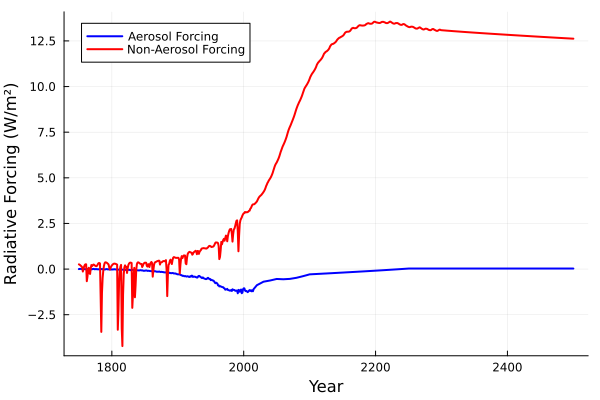

In [138]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

1. First I discretize the EBM and get the equation
$\frac{T_{t+1} * T_t}{\Delta t}  =\frac{\left( F - \lambda T \right)}{c * d}$
2. Then we can do some rearrangement to get
$T_{t+1} = T_t + \Delta t \frac{\left( F - \lambda T \right)}{c * d}$

3. Using box simulation timestep, I was able to plug the numbers in and get the plot below

temp in 2100 = 4.63


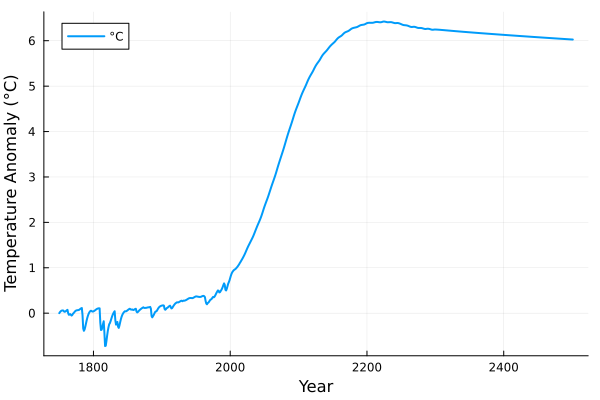

In [258]:
# Constants
c = 4.184e6  # J/K/m^2
lambda = 2.1  # °C/(W/m^2), climate feedback factor
Δt = 31_558_152  # Time step in seconds (1 year)
α = 0.8  # factor for aerosol forcing
d = 86
F = (forcing_non_aerosol .+ α .* forcing_aerosol)  # Total radiative forcing as provided

# Define the box simulation timestep function
function box_simulate_timestep(c, d, lambda, F, Temp)
     return (F - lambda * Temp) / (c * d)
end

# Define the global mean temperature simulation function
function global_mean_temp(T0, T_end, c, d, lambda, F, Δt)
    steps = Int64(T_end / Δt)  # Calculate number of steps based on total time and time step
    T = zeros(Float64, steps + 1)  # Initialize temperature array
    T[1] = T0  # Set initial temperature
    
    # Loop over all timesteps
    for t in 1:steps
        T[t+1] = T[t] + Δt * box_simulate_timestep(c, d, lambda, F[t], T[t])
    end
    
    return T
end

# Parameters for the simulation
T0 = 0.0  # Initial temperature anomaly in °C
T_end = length(F) * Δt  # Total simulation time in seconds (based on length of forcing data)

# Perform the simulation
temperature_anomalies = global_mean_temp(T0, T_end, c, d, lambda, F, Δt)
temp_2100 = round(temperature_anomalies[351], digits = 2) 
println("temp in 2100 = ", temp_2100)
# Plotting the results
years = 1750:(1750 + length(temperature_anomalies) - 1)
plot(years, label = "°C", temperature_anomalies, xlabel="Year", ylabel="Temperature Anomaly (°C)", lw=2)


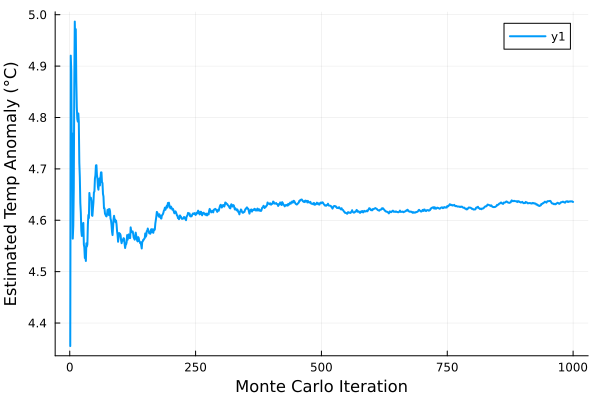

In [192]:
# Number of Monte Carlo simulations
n_simulations = 1000

# Log-normal distribution for lambda
lambda_distribution = LogNormal(log(2.1), log(2) / 4)

# Array to store temperature anomalies in 2100 for each simulation
T_2100 = zeros(Float64, n_simulations)
cumulative_means = zeros(Float64, n_simulations)  # To store cumulative mean for each iteration

# Monte Carlo loop
for i in 1:n_simulations
    lambda_sample = rand(lambda_distribution)  # Sample from log-normal distribution for lambda
    temperature_anomalies = global_mean_temp(T0, T_end, c, d, lambda_sample, F, Δt)
    T_2100[i] = temperature_anomalies[Int64((2100 - 1750) * 1)]  # Extract temperature in 2100
    
    # Calculate cumulative mean after each iteration
    cumulative_means[i] = mean(T_2100[1:i])
end

# Plot the cumulative mean vs iterations
plot(1:n_simulations, cumulative_means, xlabel="Monte Carlo Iteration", ylabel="Estimated Temp Anomaly (°C)", lw=2)


Expected final temperature in 2100: 4.722228206050399 °C
Estimated final temperature for 1000 iterations: 4.722228206050399 °C
Error between estimated and expected final temperatures for 1000 iterations (in °C): 0.0


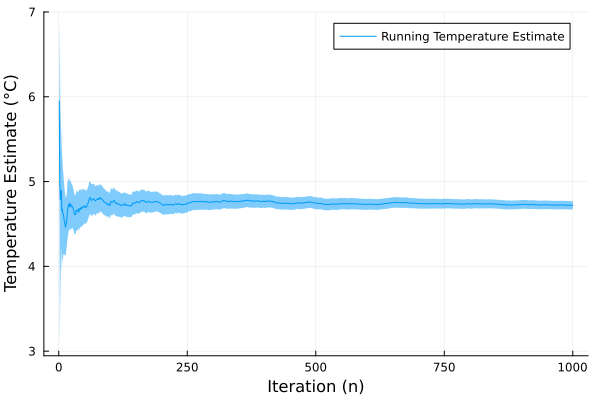

In [256]:
# Set the number of Monte Carlo iterations
n_simulations = 1000
lambda_distribution = LogNormal(log(2.1), log(2) / 4)

# Array to store temperature anomalies and standard deviations in 2100 for each simulation
T_2100 = zeros(Float64, n_simulations)
st_dev_2100 = zeros(Float64, n_simulations)

# Monte Carlo loop to calculate temperature anomalies for 2100
for i in 1:n_simulations
    lambda_sample = rand(lambda_distribution)  # Sample from log-normal distribution for lambda
    temperature_anomalies = global_mean_temp(T0, T_end, c, d, lambda_sample, F, Δt)
    
    # Extract temperature anomaly for the year 2100 (index 351)
    T_2100[i] = temperature_anomalies[351]
    
    # Calculate standard deviation up to this point
    if i > 1
        st_dev_2100[i] = std(T_2100[1:i])
    else
        st_dev_2100[i] = 0.0  # No deviation with one sample
    end
end
# Running estimate of temperature in the year 2100 relative to the year 1750
T_run_est = cumsum(T_2100) ./ (1:n_simulations)
n_vec = collect(1:n_simulations)  # Vector of iteration numbers

# Expected value of temperature (mean)
expt_temp_2100 = mean(T_2100)

# Standard error after n_simulations
st_error = st_dev_2100[end] / sqrt(n_simulations)
final_t = T_run_est[end]
error = round(abs(final_t - expt_temp_2100), digits = 2)

# Print results
println("Expected final temperature in 2100: $expt_temp_2100 °C")
println("Estimated final temperature for 1000 iterations: $final_t °C")
println("Error between estimated and expected final temperatures for 1000 iterations (in °C): $error")

# Plot the cumulative mean and the 95% confidence interval as a ribbon
plt = plot(
    n_vec, T_run_est, ribbon=1.96 * st_dev_2100 ./ sqrt.(n_vec), xlabel="Iteration (n)", ylabel="Temperature Estimate (°C)", label="Running Temperature Estimate")

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

In [137]:
function do_simulate(x, C0, B0, N0, ka, kn, kc, Cs, U)
    B = B0 * exp(-kc * x / U)
    N = N0 * exp(-kn * x / U)
    α1 = exp(-ka * x / U)
    α2 = (kc / (ka - kc)) * (exp.(-kc * x / U) - exp(-ka * x / U))
    α3 = (kn / (ka - kn)) * (exp(-kn * x / U) - exp(-ka * x / U))
    C = Cs * (1 - α1) + (C0 * α1) - (B0 * α2) - (N0 * α3)
    
    return (C, B, N)
end
# Set river properties
ka = 0.55
kc = 0.35
kn = 0.25
C0 = 7.5  
B0 = 5  
N0 = 5    
Cs = 10  
U = 6 

# Waste stream 1 properties with treatment
Q_waste1 = 10000 
C_waste1 = 5.0   
B_waste1 = 50.0 * 0.71
N_waste1 = 50.0 * 0.71  

# River flow rate
Q_river = 100000  # m³/day

# Define the range for x (distance downstream in km)
x = 0:15  # km
C1 = (Q_river * C0 + Q_waste1 * C_waste1) / (Q_river + Q_waste1)
B1 = (Q_river * B0 + Q_waste1 * B_waste1) / (Q_river + Q_waste1)
N1 = (Q_river * N0 + Q_waste1 * B_waste1) / (Q_river + Q_waste1)

# Unpack outputs into individual arrays for C, B, and N
C15 = [d[1] for d in do_out_waste1]  # DO concentration
B15 = [d[2] for d in do_out_waste1]  # CBOD concentration
N15 = [d[3] for d in do_out_waste1]  # NBOD concentration

do_out_waste1 = (y -> do_simulate(y, C1, B1, N1, ka, kc, kn, Cs, U)).(x)
# Waste stream 2 properties
Q_waste2 = 15000
C_waste2 = 5.0
B_waste2 = 45.0
N_waste2 = 35

C2i = ((Q_river + Q_waste1)*C15[15] + (Q_waste2*C_waste2))/(Q_river + Q_waste1 + Q_waste2)
B2i = ((Q_river + Q_waste1)*B15[15] + (Q_waste2*B_waste2))/(Q_river + Q_waste1 + Q_waste2)
N2i = ((Q_river + Q_waste1)*N15[15] + (Q_waste2*N_waste2))/(Q_river + Q_waste1 + Q_waste2)

x2 = 0:35

do_out_waste2 = (y -> do_simulate(y, C2i, B2i, N2i, ka, kc, kn, Cs, U)).(x2)

C50 = [d[1] for d in do_out_waste2]
B50 = [d[2] for d in do_out_waste2]
N50 = [d[3] for d in do_out_waste2]

function simulate_with_third_discharge(C2i, B2i, N2i, Q_river, Q_waste1, Q_waste2, Q_waste3, C_waste3, B_waste3, N_waste3, ka, kn, kc, Cs, U, x)
    # Calculate the mixed concentrations after the third discharge
    C3 = ((Q_river + Q_waste1 + Q_waste2) * C2i[begin] + (Q_waste3 * C_waste3)) / (Q_river + Q_waste1 + Q_waste2 + Q_waste3)
    B3 = ((Q_river + Q_waste1 + Q_waste2) * B2i[begin] + (Q_waste3 * B_waste3)) / (Q_river + Q_waste1 + Q_waste2 + Q_waste3)
    N3 = ((Q_river + Q_waste1 + Q_waste2) * N2i[begin] + (Q_waste3 * N_waste3)) / (Q_river + Q_waste1 + Q_waste2 + Q_waste3)
    
    # Simulate DO, BOD, NBOD downstream after the third discharge
    return (y -> do_simulate(y, C3, B3, N3, ka, kc, kn, Cs, U)).(x)
end

function find_distance_for_third_discharge(C50, B50, N50, Q_river, Q_waste1, Q_waste2, Q_waste3, C_waste3, B_waste3, N_waste3, ka, kn, kc, Cs, U, DO_threshold=4.0)
    for distance in 1:1:100  # Iterate over distances (in km) downstream
        x3 = 0:distance  # Simulate distance downstream of the third discharge
        do_out_third = simulate_with_third_discharge(C50, B50, N50, Q_river, Q_waste1, Q_waste2, Q_waste3, C_waste3, B_waste3, N_waste3, ka, kn, kc, Cs, U, x3)
        C_after_third = [d[1] for d in do_out_third]  # DO concentration after third discharge
        
        if minimum(C_after_third) >= 4
            return distance  # Return the minimum distance that keeps DO above the threshold
        end
    end
    return -1  # If no solution is found, return -1
end

# Waste stream 3 properties
Q_waste3 = 5  # m³/day
C_waste3 = 4.5  # mg/L (DO concentration)
B_waste3 = 50.0  # mg/L (CBOD)
N_waste3 = 45.0  # mg/L (NBOD)

# Simulate and calculate the required distance for waste stream 3

min_distance_waste3 = find_distance_for_third_discharge(C2i, B2i, N2i, Q_river, Q_waste1, Q_waste2, Q_waste3, C_waste3, B_waste3, N_waste3, ka, kn, kc, Cs, U)
println("Minimum distance for the third discharge to keep DO above 4 mg/L: $min_distance_waste3 km")


Minimum distance for the third discharge to keep DO above 4 mg/L: 1 km


## References

List any external references consulted, including classmates.